In [1]:
import cv2
from PIL import Image

In [2]:
imagePath = '/home/mh/medical/000_HC.png'
image=cv2.imread(imagePath) 
img = Image.open(imagePath)

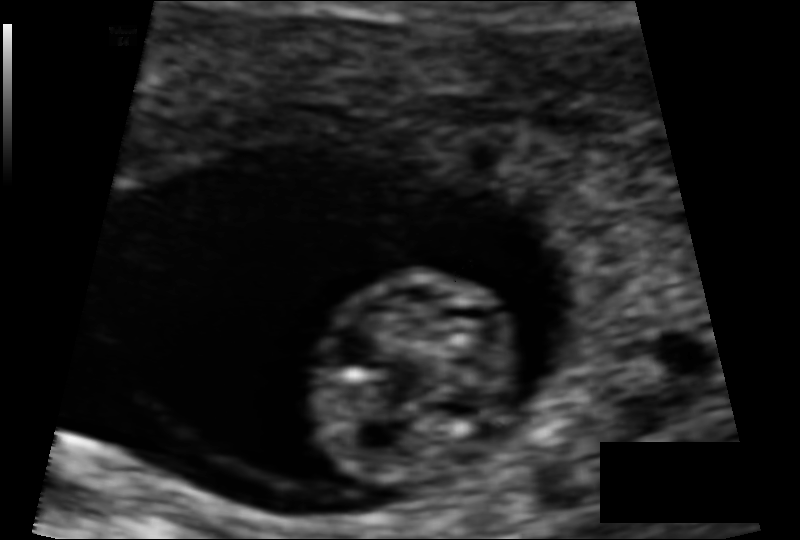

In [3]:
# cv2.imshow('test.jpg',image)
img.show()
img

In [4]:
# 构建gabor滤波器提取纹理特征（浅层特征） ,并进行灰度直方图均衡化处理（数字图像处理方面的知识、原理暂时不是很清楚）
import numpy as np
import os
import cv2

def pathFile(path):
    return os.getcwd() + '/' + path

def brightestColumn(img):
    w, h = img.shape
    r = range(int(h / 2), h - 1)
    c = range(0, w - 1)
    return img[c][:,r].sum(axis=0).argmax()

#构建GABOR滤波器
def build_filters():
    """ returns a list of kernels in several orientations
    """
    filters = []
    ksize = 31                                                                 #gaborl尺度 这里是一个
    for theta in np.arange(0, np.pi, np.pi / 4):                               #gaborl方向 0 45 90 135 角度尺度的不同会导致滤波后图像不同
        
        params = {'ksize':(ksize, ksize), 'sigma':3.3, 'theta':theta, 'lambd':18.3,    
                  'gamma':4.5, 'psi':0.89, 'ktype':cv2.CV_32F}
                                                                            #gamma越大核函数图像越小，条纹数不变，sigma越大 条纹和图像都越大
                                                                            #psi这里接近0度以白条纹为中心，180度时以黑条纹为中心
                                                                            #theta代表条纹旋转角度
                                                                            #lambd为波长 波长越大 条纹越大
        kern = cv2.getGaborKernel(**params)                                    #创建内核
        kern /= 1.5*kern.sum()
        filters.append((kern,params))
    return filters                                                          

#滤波过程
def process(img, filters):
    """ returns the img filtered by the filter list
    """
    accum = np.zeros_like(img)                                              #初始化img一样大小的矩阵
    for kern,params in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)                         #2D滤波函数  kern为其滤波模板
        np.maximum(accum, fimg, accum)                                      #参数1与参数2逐位比较  取大者存入参数3  这里就是将纹理特征显化更加明显
    return accum

#获取感兴趣区域的top 和 bottom值 用于切割显示图像
def getRoiHCut2(img, p0):
    h, w = img.shape

    maxTop = np.argmax(img[0: int(h / 2), 0])                                    #在一定区域遍历选取目标边缘 具体高宽结合图像
    minTop = np.argmax(img[0: int(h / 2), w-1])
    if(maxTop < 65):
        maxBottom = np.argmax(img[(13 * int(h / 16)): 40*int(h/48)  , 0]) + 3 * int(h / 4)
        minBottom = np.argmax(img[(13 * int(h / 16)): 40*int(h/48), w-1]) + 3 * int(h / 4)
    else:
        maxBottom = np.argmax(img[(3 * int(h / 4)): h  , 0]) + 3 * int(h / 4)
        minBottom = np.argmax(img[(3 * int(h / 4)): h, w-1]) + 3 * int(h / 4)
    maxTop = int((2*maxTop + minTop) / 3)
    maxBottom = int((maxBottom + 2*minBottom) / 3)

    return img[maxTop:maxBottom,:]

#获取感兴趣区域范围
def getRoi(img):
    height, width = img.shape
    height = int(height)
    height = int(width)
    heightDist = int(height / 4)

    w = img.copy()
    w1 = w[heightDist:3 * heightDist,int(width / 4):]
    p0 = brightestColumn(w1) + heightDist + int(height / 2)                      #将手指边缘的高度加上四分之三原始高度  
    pCol = w[:,p0:p0 + 1]

    pColInv = pCol[::-1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))              #构建一个有限对比适应性直方图均衡化器  

    w1_2 = clahe.apply(w[:, int(p0 /20):int(p0 + p0 / 2)])                       #截取区域宽度大概是p0高度的一点五倍 apply是获取一个返回值 这里是为了方便参数的传递
    w2 = getRoiHCut2(w1_2, p0)

    res = cv2.resize(w2, (270, 150), interpolation=cv2.INTER_CUBIC)

    return clahe.apply(res)

def logImg(img):
    return img.astype(float) / 255                                          #将图像数据转为０－１存储

mDir=[]
imgs = []
dbDir = os.getcwd() + "/Fingerprint_Enhancement_Python/images/"
people = os.listdir(dbDir)
people.sort()

for peo in people:
    handDir = dbDir + peo
    mDir += [handDir]
    imgs = imgs + [handDir]
    
p0Imgs = [i.replace('images', 'enhanced') for i in imgs]                         
#p0Imgs是每个文件的路径，mDir是需要创建路径所有文件夹存放预处理后图片
mDir = [i.replace('images', 'enhanced') for i in mDir]

filters = build_filters()
for index, imgPath  in enumerate(imgs):
    img = cv2.imread(imgPath, 0)
    res0 = process(getRoi(img), filters)                                        #获取ROI进行直方图均衡化,切割后再gabor滤波
    cv2.imwrite(p0Imgs[index], res0)
print ('处理完成！')

处理完成！


In [8]:
# 处理前后对比示例
##原图片
imagePath_gabor = '/home/mh/medical/Fingerprint_Enhancement_Python/enhanced/1.png'
im = cv2.resize(img, (270, 150), interpolation=cv2.INTER_CUBIC) #做了翻
im=Image.fromarray(im)
##Gabor滤波处理后的图片
img_ga = Image.open(imagePath_gabor)

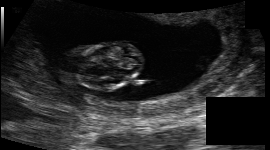

In [9]:
# resize尺寸未调好，有一定拉伸
im

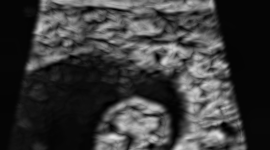

In [10]:
# 感兴趣区域范围的提取，生成纹理图片（未调参，区域crop不是很精确，但这里明显把纹理特征显著化了）
img_ga

In [12]:
# 上述纹理特征，通过构建Circular-LBP局部二值化模式，除了可以增强纹理，还能提取形状规则方面的特征（也是浅层特征之一） （人脸对齐也会用到）
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

#双极性插值
def bilinear_interpolation(x, y, img):
    x1, y1 = int(r), int(c)
    x2, y2 = math.ceil(r), math.ceil(c)

    r1 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y1) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y1)
    r2 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y2) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y2)

    return (y2 - y) / (y2 - y1) * r1 + (y - y1) / (y2 - y1) * r2    

#阈值设置
def thresholded(center, pixels):
    out = []
    for a in pixels:
        if a >= center:
            out.append(1)
        else:
            out.append(0)
    return out

#像素返回
def get_pixel_else_0(l, idx, idy):
    if idx < int(len(l)) - 1 and idy < len(l[0]):
        return l[idx,idy]
    else:
        return 0

#读取图像
img = cv2.imread('/home/mh/medical/Fingerprint_Enhancement_Python/enhanced/1.png', 0)
transformed_img = cv2.imread('/home/mh/medical/Fingerprint_Enhancement_Python/enhanced/1.png', 0)

#相邻像素P和半径R
P = 8 # number of pixels 1中心像素点、8领域像素点
R = 1 # radius 半径

for x in range(0, len(img)):
    for y in range(0, len(img[0])):
        center        = img[x,y]
        pixels = []
        for point in range(0, P):
            r = x + R * math.cos(2 * math.pi * point / P)
            c = y - R * math.sin(2 * math.pi * point / P)
            if r < 0 or c < 0:
                pixels.append(0)
                continue            
            if int(r) == r:
                if int(c) != c:
                    c1 = int(c)
                    c2 = math.ceil(c)
                    w1 = (c2 - c) / (c2 - c1)
                    w2 = (c - c1) / (c2 - c1)
                                    
                    pixels.append(int((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                                   w2 * get_pixel_else_0(img, int(r), math.ceil(c))) / (w1 + w2)))
                else:
                    pixels.append(get_pixel_else_0(img, int(r), int(c)))
            elif int(c) == c:
                r1 = int(r)
                r2 = math.ceil(r)
                w1 = (r2 - r) / (r2 - r1)
                w2 = (r - r1) / (r2 - r1)                
                pixels.append((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                               w2 * get_pixel_else_0(img, math.ceil(r), int(c))) / (w1 + w2))
            else:
                pixels.append(bilinear_interpolation(r, c, img))

                
        values = thresholded(center, pixels)
        res = 0
        for a in range(0, len(values)):
            res += values[a] * (2 ** a)

        transformed_img.itemset((x,y), res)

cv2.imwrite('/home/mh/medical/Fingerprint_Enhancement_Python/enhanced/1_lbp.png',transformed_img)
print('处理完成！')

处理完成！


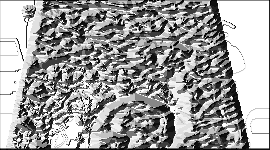

In [15]:
# 生成带形状规则特征的纹理增强图片
img_ga_lbp=Image.fromarray(transformed_img)
img_ga_lbp

In [ ]:
#　根据上述形状、纹理特征，完全基于机器学习数字图像处理的方法，先测试下ASM（自主形状）模型的baby头部边缘轮廓提取效果
im